See the parent `Input_prep.ipynb` notebook. © 2021 Kajetan Chrapkiewicz.

#### Notebook config

In [1]:
import numpy as np

In [2]:
# %load fwipy_config.py 

# -----------------------------------------------------------------------------
# Load default modules defined in fullwavepy/__init__.py
# -----------------------------------------------------------------------------
from fwipy import *


# -----------------------------------------------------------------------------
# Set aliases of frequently used jupyter magic commands
# -----------------------------------------------------------------------------
%alias_magic mi matplotlib -p inline
%alias_magic mn matplotlib -p notebook


# -----------------------------------------------------------------------------
# Configure matplotlib
# -----------------------------------------------------------------------------
# SET DEFAULT backend:
# non-interactive plots displayed in a notebook cell
%matplotlib inline
# OTHER OPTIONS: %matplotlib notebook (interactive version)
# -----------------------------------------------------------------------------
# NOTE: ALREADY SET IN fwi.plot.specific.mpl.Fig.__init__
# SET DEFAULT style:
# plt.style.reload_library()
# a combined style (right overwrites left wherever they overlap):
# plt.style.use(['default', 'ggplot', 'fwipy'])
# OTHER OPTIONS: print(plt.style.available)


# -----------------------------------------------------------------------------
# Configure logging
# -----------------------------------------------------------------------------
# Set up loggers, handlers etc. 
# and load the log_lvl function
from fwipy.config.logging import *
# -----------------------------------------------------------------------------
# SET DEFAULT level of log-messages to display
log_lvl(INFO)
# OTHER OPTIONS: TRACE, DEBUG, INFO, WARNING, ERROR, CRITICAL
# or using integers: 0, 10, 20, 30, 40, 50 respectively
# (in order of increasing importance/dicreasing ver.shellity)


# -----------------------------------------------------------------------------
# Other notebook's configuration
# -----------------------------------------------------------------------------
# Autocompleting
%config IPCompleter.greedy=True 
# -----------------------------------------------------------------------------
# Automatically reload modules before execution
#%load_ext autoreload
#%autoreload 2

Created `%mi` as an alias for `%matplotlib inline`.
Created `%mn` as an alias for `%matplotlib notebook`.


In [3]:
path_eph = '/home/kmc3817/rds_home/my_ephemeral/PROJECTS/ch_inp/'

In [4]:
lll(40)
from fullwavepy.ioapi.proteus import ProteusExperiment
pro = ProteusExperiment()

In [5]:
from fwilight.ndat import A3d, A2d

# P-wave velocity

### Latest

#### Alg.
Read the final $v_P$ model from the travel-time tomography by Heath19; it is discretised on a vertically sheared grid conforming to the seafloor and land topography.

In [16]:
%%time 
# This model **isotropic slowness** output from TomoLab travel-time inversion code 
# (https://pages.uoregon.edu/drt/Stingray/, Stingray/TomoLab Overview),
# **still on a sheared grid**.
# - a MATLAB structure containing the (slowness) model and meta data 
# (e.g. elevation used to shear the grid vertically)
# - some of the fields are redundant and defined only for convenience
# - it5 means it was reached after only 5 inversion iterations (see Ben's paper)
from scipy.io import loadmat
from fullwavepy.seismic.models import StartVp
fname = '/home/kmc3817/heavy_PhD/start_mods/srModel_it5_19-04-25.mat' # MODEL FROM BEN (25.04.2019)
mat = loadmat(fname, struct_as_record=False)
srModel = mat['srModel'][0,0] # A SINGLE STRUCT IS AN ARRAY OF A SHAPE (1, 1)
# print('srModel.ghead[0]', srModel.ghead[0])
# Calculate extent 
x1, y1, nx, ny, nz, dx, dy, dz = srModel.ghead[0]
dx, dy, dz = np.array([dx, dy, dz]) * 1000 # m
nx, ny, nz = int(nx), int(ny), int(nz)
dims = [nx, ny, nz]

x1, y1 = x1 * 1000, y1 * 1000 # km -> m
x1_srModel, y1_srModel = x1, y1
x2 = x1 + (nx - 1) * dx  
y2 = y1 + (ny - 1) * dy 
# print x2, y2 # srModel.maxx, srModel.maxy

# print('x1, y1, x2, y2 [m]: ', x1, y1, x2, y2)
# print('nx, ny, nz [nodes]: ', nx, ny, nz) 
# print('dx, dy, dz [m]: ', dx, dy, dz) 

# Convert from isotropic slowness in s/km to velocity in m/s
s = srModel.u 
v = StartVp(np.reciprocal(s) * 1000)
v.extent[ :2] = [[x1, x2], [y1, y2]]
v.extent[2] = [0, (v.extent[2][-1]) * dz] # otherwise 0,60 nodes
v.dx = [dx, dy, dz]
print('vmin=%.2f m/s, vmax=%.2f m/s' % (np.min(v), np.max(v)))
vp = StartVp(np.copy(v), extent=v.extent)
del v

vmin=1687.18 m/s, vmax=9216.23 m/s
CPU times: user 992 ms, sys: 132 ms, total: 1.12 s
Wall time: 1.19 s


#### Fig.
Final $v_P$ model from the travel-time tomography by Heath19; it is discretised on a vertically sheared grid conforming to the seafloor and land topography.

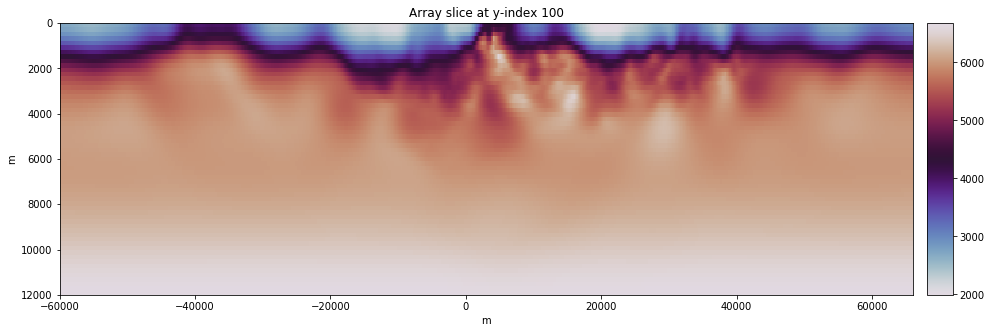

In [26]:
figure(16,5)
ax = vp.plot(100)
_ = ax.set_xlabel('m')
_ = ax.set_ylabel('m')

#### Alg.
Cutting the above model to the area of interest.

In [7]:
# code 
from fwilight.ndat import A3d
x1 = -2.0e4
x2 = +2.0e4
y1 = -5.0e3
y2 = +2.0e4
z1 = 0
z2 = 6.0e3
box = [x1, x2, y1, y2, z1, z2]
vp1 = vp.carve(box)
vp1 = A3d(vp1)

#### Fig.
Slices of the final model of travel-time tomography (Heath19) dicretised on a vertically sheared grid cut to the area of interest.

##### a) 
Vertical slice along Y axis at x=0 m.

CPU times: user 24 ms, sys: 4 ms, total: 28 ms
Wall time: 26 ms


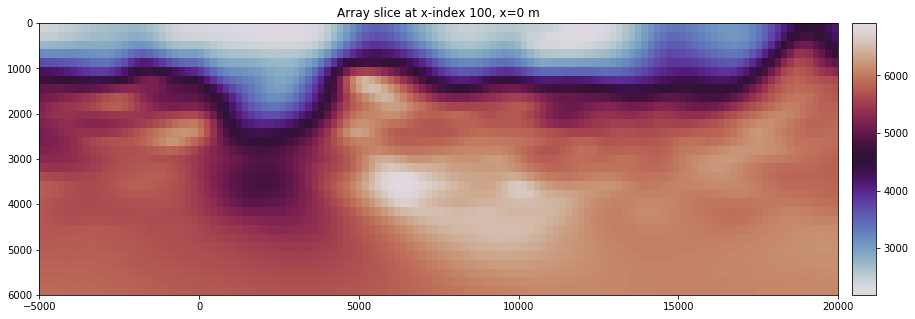

In [66]:
%%time 
figure(15,5)
ax = vp1.plot(0, unit='m', axis='x', cmap='twilight')

##### b)
Vertical slice along X axis at y=0 m.

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 29.4 ms


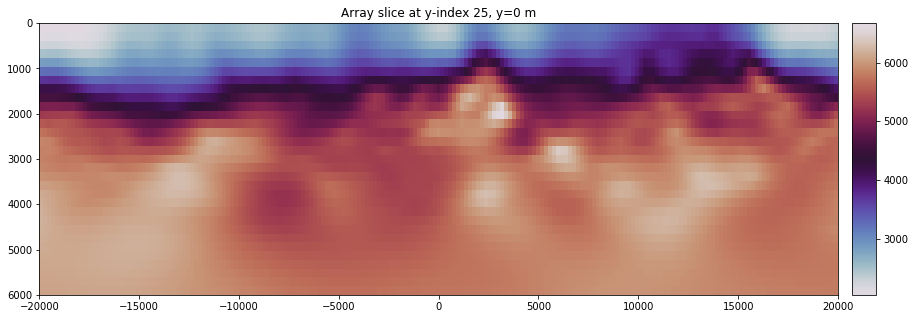

In [67]:
%%time 
figure(15,5)
ax = vp1.plot(0, unit='m', axis='y', cmap='twilight')

##### c)
Horizontal slice at z=2000 m **from the top of the sheared** model.

CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 26 ms


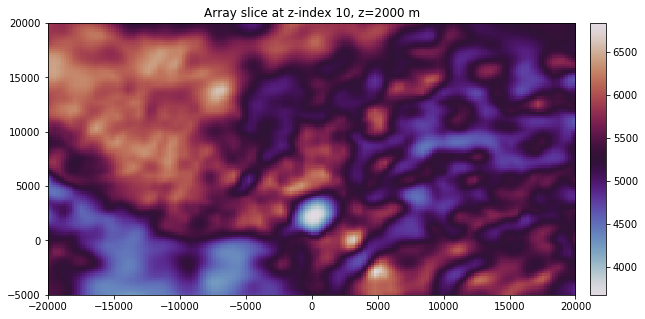

In [68]:
%%time 
figure(10,5)
ax = vp1.plot(2000, unit='m', axis='z', cmap='twilight')
# _ = ax.set_xlim(-2e4,2e4)

#### Fig.
Bathymetry and topography in full extent.

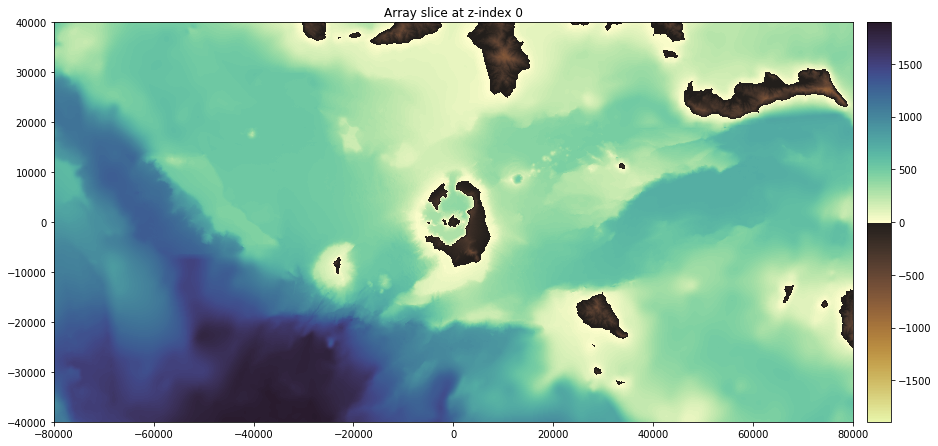

In [6]:
# code 
bt = pro.bathytopo
import cmocean.cm as cm
figure(15,10)
ax = Arr3d(bt).plot(z=0, cmap=[cm.turbid, cm.deep], center_cmap=1, aspect='equal')

#### Alg.
Cutting the bathymetry and topography to the same extent as the model.

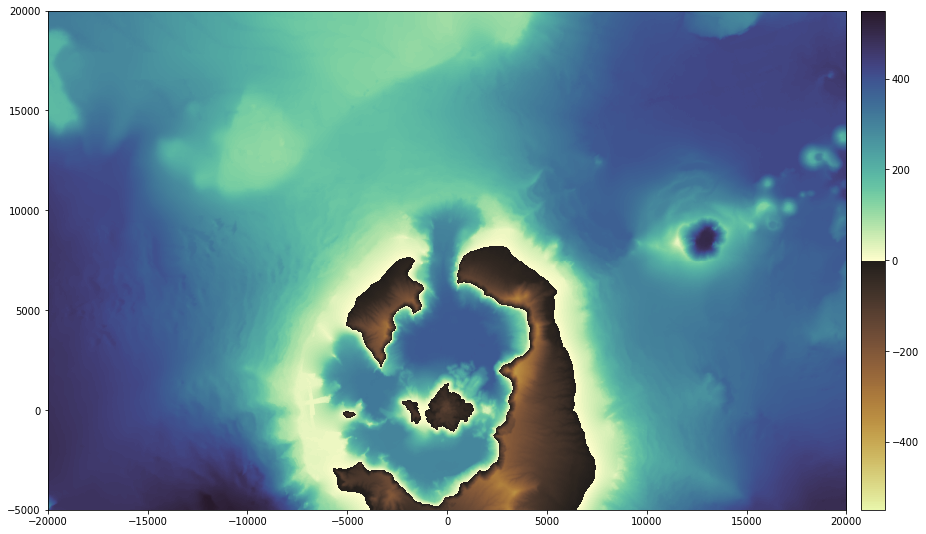

In [8]:
# code 
import cmocean.cm as cm
bt = Arr3d(pro.bathytopo).slice(slice_at='z')
bt.dx = [50.,50.]
bt = bt.carve(box[:-2])
bt.extent[1] = bt.extent[1][::-1] # FIXME
figure(15,10)
ax = bt.plot(cmap=[cm.turbid, cm.deep], center_cmap=1, aspect='equal')
ax.invert_yaxis()

#### Fig.
Histogram of bathymetry and topography depths.

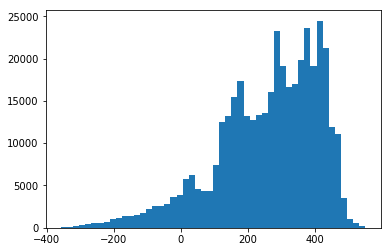

In [194]:
_ = plt.hist(np.ravel(bt), bins=50) #range=np.min(bt),np.max(bt))

#### Fig.
Different modes of padding shown with a vertical model slice<div class="cite2c-biblio"></div> along X axis at y=0 m:

##### a)
constant (zero)

vp3.shape [801, 501, 51], vp3.extent: [[-20000.0, 20000.0], [-5000.0, 20000.0], [-2000.0, 8000.0]]
CPU times: user 72 ms, sys: 216 ms, total: 288 ms
Wall time: 287 ms


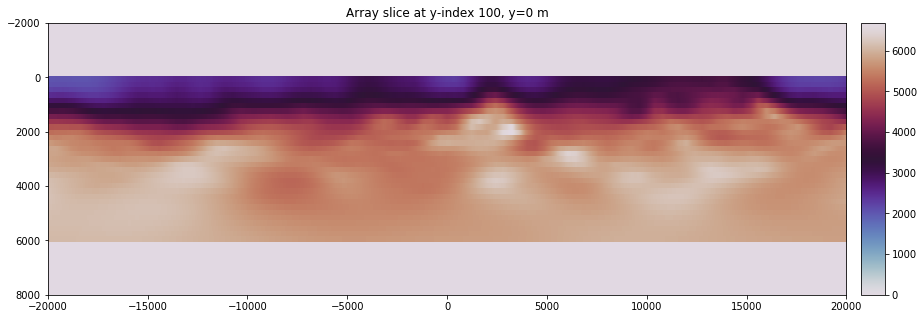

In [240]:
%%time 
zpad1 = 10
zpad2 = 10

vp3 = np.pad(vp2, pad_width=((0,0),(0,0),(zpad1,zpad2)), mode='constant')

dz = vp2.dx[-1]
extent = list(vp2.extent[:-1]) + [np.array([-zpad1*dz, vp2.extent[-1][-1] + zpad2*dz])]
vp3 = A3d(vp3, extent=extent)
print('vp3.shape %s, vp3.extent: %s' % (list(vp3.shape), [list(i) for i in vp3.extent]))
figure(15,5)
ax = vp3.plot(0, **kws)

##### b)
linear ramp

vp3.shape [801, 501, 51], vp3.extent: [[-20000.0, 20000.0], [-5000.0, 20000.0], [-2000.0, 8000.0]]
CPU times: user 76 ms, sys: 16 ms, total: 92 ms
Wall time: 89.6 ms


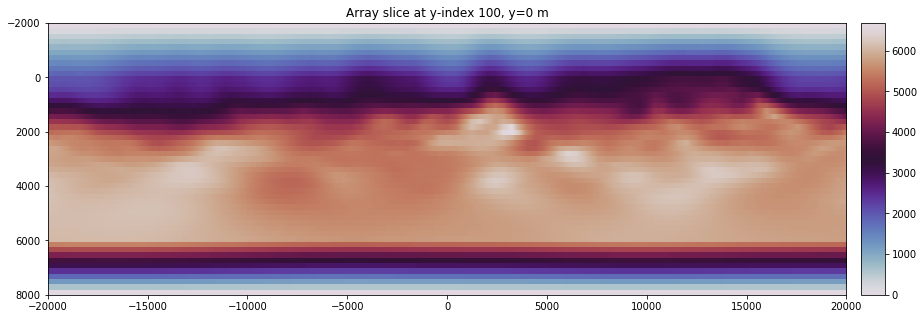

In [241]:
%%time 
zpad1 = 10
zpad2 = 10

vp3 = np.pad(vp2, pad_width=((0,0),(0,0),(zpad1,zpad2)), mode='linear_ramp')

dz = vp2.dx[-1]
extent = list(vp2.extent[:-1]) + [np.array([-zpad1*dz, vp2.extent[-1][-1] + zpad2*dz])]
vp3 = A3d(vp3, extent=extent)
print('vp3.shape %s, vp3.extent: %s' % (list(vp3.shape), [list(i) for i in vp3.extent]))
figure(15,5)
ax = vp3.plot(0, **kws)

##### c)
with the edge values of array

vp3.shape [801, 501, 51], vp3.extent: [[-20000.0, 20000.0], [-5000.0, 20000.0], [-2000.0, 8000.0]]
CPU times: user 116 ms, sys: 184 ms, total: 300 ms
Wall time: 299 ms


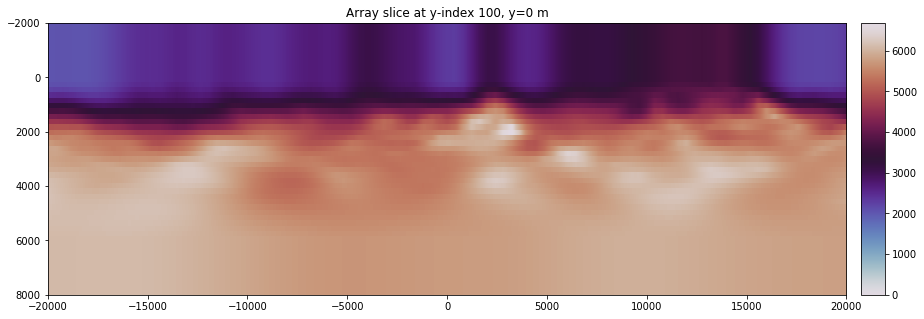

In [242]:
%%time 
zpad1 = 10
zpad2 = 10

vp3 = np.pad(vp2, pad_width=((0,0),(0,0),(zpad1,zpad2)), mode='edge')

dz = vp2.dx[-1]
extent = list(vp2.extent[:-1]) + [np.array([-zpad1*dz, vp2.extent[-1][-1] + zpad2*dz])]
vp3 = A3d(vp3, extent=extent)
print('vp3.shape %s, vp3.extent: %s' % (list(vp3.shape), [list(i) for i in vp3.extent]))
figure(15,5)
ax = vp3.plot(0, **kws)

##### b)
Comparison to unpadded model to ensure padding did not change the values inside.

CPU times: user 104 ms, sys: 0 ns, total: 104 ms
Wall time: 99.4 ms


(8000.0, -2000.0)

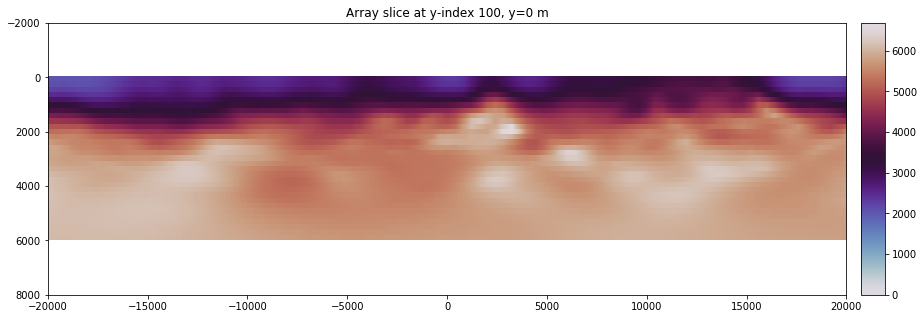

In [171]:
%%time 
figure(15,5)
kws = dict(unit='m', axis='y', cmap='twilight', vmin=0)
ax = vp2.plot(0, **kws)
ax.set_ylim(vp3.extent[-1][::-1])

#### Alg.
Shearing back a 1d profile.

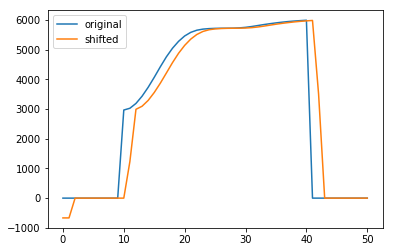

In [219]:
# code 
i = 0 
j = 0
m = vp3[i,j]
b = bt[i,j]
dz = 200

plt.plot(m, label='original')
plt.plot(shift(m, b/dz, order=1, mode='constant', cval=-666), label='shifted')
_ = plt.legend()

In [59]:
from scipy.ndimage import shift
help(shift)

Help on function shift in module scipy.ndimage.interpolation:

shift(input, shift, output=None, order=3, mode='constant', cval=0.0, prefilter=True)
    Shift an array.
    
    The array is shifted using spline interpolation of the requested order.
    Points outside the boundaries of the input are filled according to the
    given mode.
    
    Parameters
    ----------
    input : array_like
        The input array.
    shift : float or sequence
        The shift along the axes. If a float, `shift` is the same for each
        axis. If a sequence, `shift` should contain one value for each axis.
    output : array or dtype, optional
        The array in which to place the output, or the dtype of the
        returned array. By default an array of the same dtype as input
        will be created.
    order : int, optional
        The order of the spline interpolation, default is 3.
        The order has to be in the range 0-5.
    mode : {'reflect', 'constant', 'nearest', 'mirror', 'wra

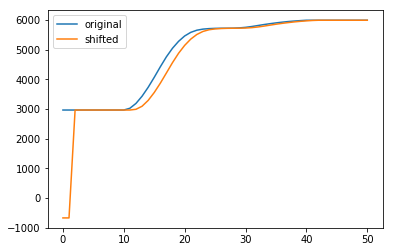

In [245]:
# code 
i = 0 
j = 0
m = vp3[i,j]
b = bt[i,j]
dz = 200

plt.plot(m, label='original')
plt.plot(shift(m, b/dz, order=1, mode='constant', cval=-666), label='shifted')
_ = plt.legend()

#### Alg.
Upsample the model both horizontally (same as topography) and vertically (as fine as possible).

In [9]:
def resample(arr, dx_new, dy_new, dz_new):
    """
    Prepare the correct sampling rate.
    Note that doubling the the number of 
    samples, changes the sampling interval!
    To see this, consider e.g. a 4-sample 
    signal. To preserve the extent, and halve the 
    sample (cell or node) size,  we would have to
    aim for 7 samples NOT 8 samples!
    Visualisation:
    * * * * - 4 samples 
    ******* - 7 samples 

    So dx is not halved!
    """
    def no_of_nodes(x1, x2, dx):
        """
        Reverse of what Arr._set_dx does
        """
        return ((x2 - x1) / dx) + 1
    nx, ny, nz = arr.shape
    (x1,x2), (y1,y2), (z1,z2) = arr.extent
    dx, dy, dz = arr.dx
    nx_new = no_of_nodes(x1,x2,dx_new)
    ny_new = no_of_nodes(y1,y2,dy_new)
    nz_new = no_of_nodes(z1,z2,dz_new)
    print('nx, nx_new', nx, nx_new)
    print('ny, ny_new', ny, ny_new)
    print('nz, nz_new', nz, nz_new)
    from scipy.ndimage import zoom
    # https://stackoverflow.com/questions/47775621/interpolate-resize-3d-array
    # This is probably the best approach, 
    # the zoom method is designed for precisely this kind of task.
    # from scipy.ndimage import zoom
    # new_array = zoom(array, (0.5, 0.5, 2))
    # changes the size in each dimension by the specified factor. 
    # If the original shape of array was, say, (40, 50, 60), 
    # the new one will be (20, 25, 120). 
    narr = zoom(arr, (nx_new / nx, ny_new/ny, nz_new/nz))
    print('narr.shape:', narr.shape)

    from sys import getsizeof
    print('size of vp2: %.2f MB' % (getsizeof(narr)/1024**2))

    narr = A3d(narr, extent=vp1.extent)
    print('narr.extent, narr.dx', narr.extent, narr.dx)
    return narr
%time vp2 = resample(vp1, 50, 50, 10)

nx, nx_new 201 801.0
ny, ny_new 126 501.0
nz, nz_new 31 601.0
narr.shape: (801, 501, 601)
size of vp2: 1840.07 MB
narr.extent, narr.dx [[-20000.  20000.]
 [ -5000.  20000.]
 [     0.   6000.]] [50. 50. 10.]
CPU times: user 1min 5s, sys: 316 ms, total: 1min 6s
Wall time: 1min 6s


#### Alg.
Pad top and bottom of the model.

narr.shape [801, 501, 801], narr.extent: [[-20000.0, 20000.0], [-5000.0, 20000.0], [-1000.0, 7000.0]]
CPU times: user 528 ms, sys: 2.72 s, total: 3.24 s
Wall time: 3.25 s


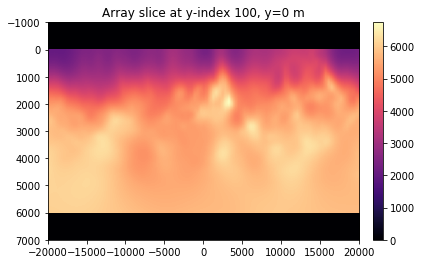

In [10]:
%%time 
def pad_z(arr, zpad1, zpad2):
    narr = np.pad(arr, pad_width=((0,0),(0,0),(zpad1,zpad2)), mode='constant')
    dz = arr.dx[-1]
    extent = list(arr.extent[:-1]) + [np.array([-zpad1*dz, arr.extent[-1][-1] + zpad2*dz])]
    narr = A3d(narr, extent=extent)
    print('narr.shape %s, narr.extent: %s' % (list(narr.shape), [list(i) for i in narr.extent]))
    return narr
vp3 = pad_z(vp2, 100, 100)
vp3.plot(0, unit='m', axis='y', cmap='magma')

In [13]:
help(np.pad)

Help on function pad in module numpy:

pad(array, pad_width, mode='constant', **kwargs)
    Pad an array.
    
    Parameters
    ----------
    array : array_like of rank N
        The array to pad.
    pad_width : {sequence, array_like, int}
        Number of values padded to the edges of each axis.
        ((before_1, after_1), ... (before_N, after_N)) unique pad widths
        for each axis.
        ((before, after),) yields same before and after pad for each axis.
        (pad,) or int is a shortcut for before = after = pad width for all
        axes.
    mode : str or function, optional
        One of the following string values or a user supplied function.
    
        'constant' (default)
            Pads with a constant value.
        'edge'
            Pads with the edge values of array.
        'linear_ramp'
            Pads with the linear ramp between end_value and the
            array edge value.
        'maximum'
            Pads with the maximum value of all or part of

#### Alg.
Shear vertically.

CPU times: user 14.4 s, sys: 2.98 s, total: 17.4 s
Wall time: 17.4 s


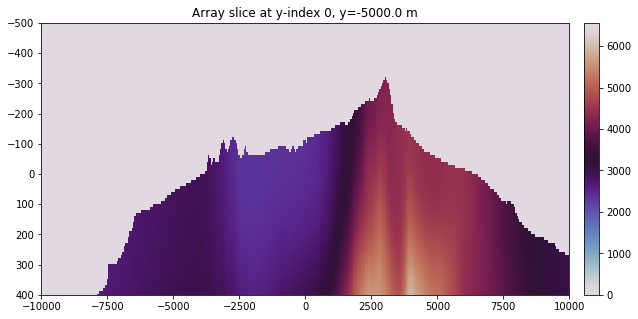

In [11]:
%%time
def reshear(vp, bt, order=0):
    from scipy.ndimage import shift
    dz = vp.dx[-1] # dble-check
    fill_val = -666
    nvp = vp.copy()
    for i in range(vp.shape[0]):
        for j in range(vp.shape[1]):    
            nvp[i,j] = shift(vp[i,j], bt[i,j]/dz, order=order, mode='constant', prefilter=False)
    return A3d(nvp, extent=vp.extent)
vp4 = vp3
vp5 = reshear(vp4, bt, order=0)
figure(10,5)
ax = vp5.plot(-5e3, unit='m', axis='y', cmap='twilight')
_ = ax.set_xlim(-1e4,1e4)
_ = ax.set_ylim(4e2,-5e2)

In [78]:
help(shift)

Help on function shift in module scipy.ndimage.interpolation:

shift(input, shift, output=None, order=3, mode='constant', cval=0.0, prefilter=True)
    Shift an array.
    
    The array is shifted using spline interpolation of the requested order.
    Points outside the boundaries of the input are filled according to the
    given mode.
    
    Parameters
    ----------
    input : array_like
        The input array.
    shift : float or sequence
        The shift along the axes. If a float, `shift` is the same for each
        axis. If a sequence, `shift` should contain one value for each axis.
    output : array or dtype, optional
        The array in which to place the output, or the dtype of the
        returned array. By default an array of the same dtype as input
        will be created.
    order : int, optional
        The order of the spline interpolation, default is 3.
        The order has to be in the range 0-5.
    mode : {'reflect', 'constant', 'nearest', 'mirror', 'wra

#### Fig.
Model resheared by the author vs. originally obtained.

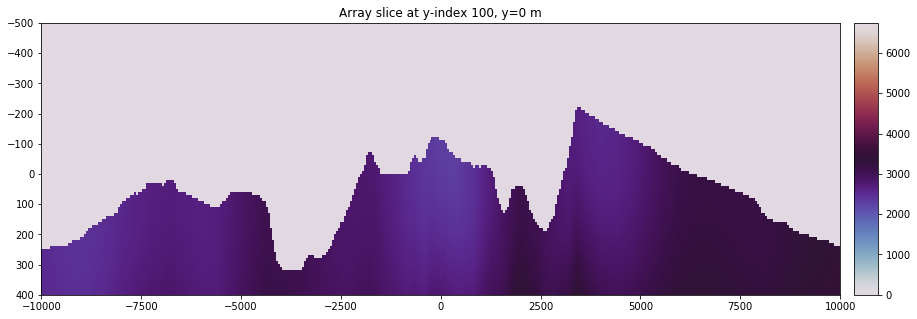

In [16]:
# code 
figure(15,5)
ax = vp5.plot(0, unit='m', axis='y', cmap='twilight')
_ = ax.set_xlim(-1e4,1e4)
_ = ax.set_ylim(4e2,-5e2)

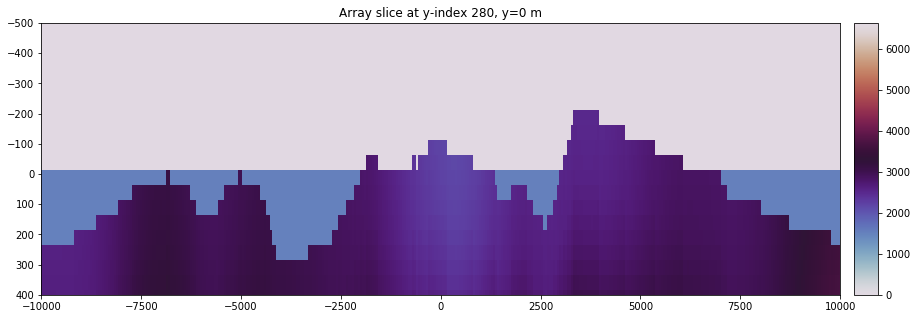

In [36]:
# code 
from fullwavepy.ioapi.proteus import ProteusExperiment
from fwilight.ndat import A3d
lll(40)
pro = ProteusExperiment()
bh = pro.svp['bh']['18-04-24']
figure(15,5)
a = A3d(bh)
ax = a.plot(0, unit='m', axis='y', cmap='twilight')
_ = ax.set_xlim(-1e4,1e4)
_ = ax.set_ylim(4e2,-5e2)

#### Alg.
Split the model into **solid and fluid** (water or air) domains via an array mask with values of 0 and 1 respectively.

CPU times: user 640 ms, sys: 3.72 s, total: 4.36 s
Wall time: 4.36 s


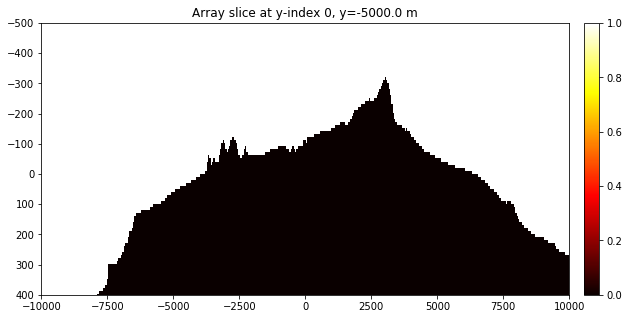

In [12]:
%%time 
mk1 = A3d((vp5 == 0).astype(int), extent=vp5.extent)
figure(10,5)
ax = mk1.plot(-5e3, unit='m', axis='y', cmap='hot')
_ = ax.set_xlim(-1e4,1e4)
_ = ax.set_ylim(4e2,-5e2)

#### Alg.
Split the model into **below and above sea level** domains via an array mask with values of 0 and 1 respectively.

CPU times: user 180 ms, sys: 348 ms, total: 528 ms
Wall time: 526 ms


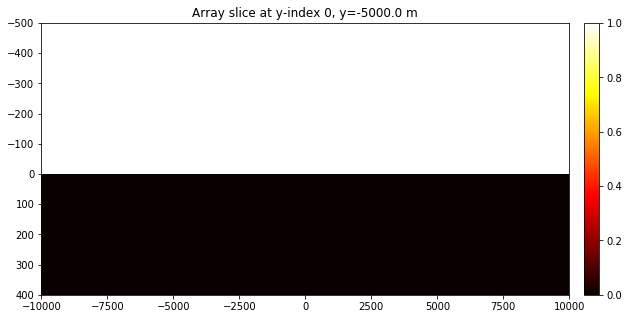

In [13]:
%%time 
z1 = vp5.extent[-1][0]
dz = vp5.dx[-1]
k_sea = int((0 - z1) / dz)
mk2 = A3d(np.zeros(vp5.shape), extent=vp5.extent)
mk2[..., :k_sea] = 1
figure(10,5)
ax = mk2.plot(-5e3, unit='m', axis='y', cmap='hot')
_ = ax.set_xlim(-1e4,1e4)
_ = ax.set_ylim(4e2,-5e2)

#### Alg.
Split the model into **air and non-air** domains via an array mask with values of 0 and 1 respectively multiplying out the two previous masks.

CPU times: user 1.1 s, sys: 3.48 s, total: 4.58 s
Wall time: 4.59 s


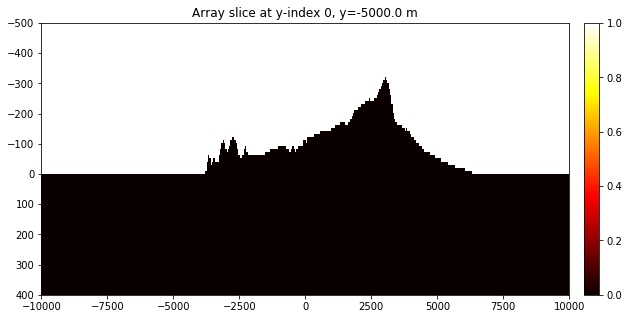

In [14]:
%%time 
mk3 = A3d(mk1*mk2, extent=vp5.extent)
figure(10,5)
ax = mk3.plot(-5e3, unit='m', axis='y', cmap='hot')
_ = ax.set_xlim(-1e4,1e4)
_ = ax.set_ylim(4e2,-5e2)

#### Alg.
Split the model into **water and non-water** domains via an array mask with values of 1 and 0. 

CPU times: user 1.91 s, sys: 8.6 s, total: 10.5 s
Wall time: 10.5 s


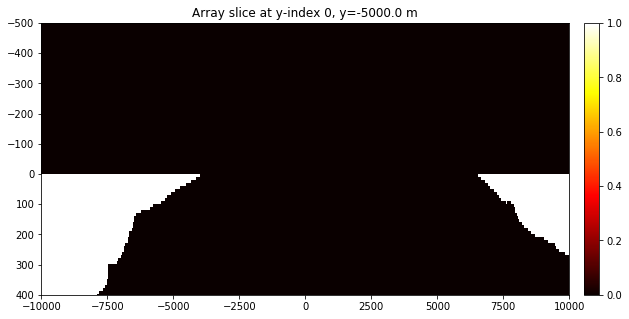

In [15]:
%%time
mk5 = A3d(-(mk2-1)*mk1, extent=vp5.extent)
figure(10,5)
ax = mk5.plot(-5e3, unit='m', axis='y', cmap='hot')
_ = ax.set_xlim(-1e4,1e4)
_ = ax.set_ylim(4e2,-5e2)

#### Alg.
Add water mask to the model.

In [17]:
%%time
vw = 1520 # m/s -  average of XBT
vp6 = A3d(vp5 + mk5 * vw, extent=vp5.extent)

CPU times: user 1.08 s, sys: 6.37 s, total: 7.45 s
Wall time: 7.46 s


#### Fig.
Model with added water.

##### a)
vertical slice.

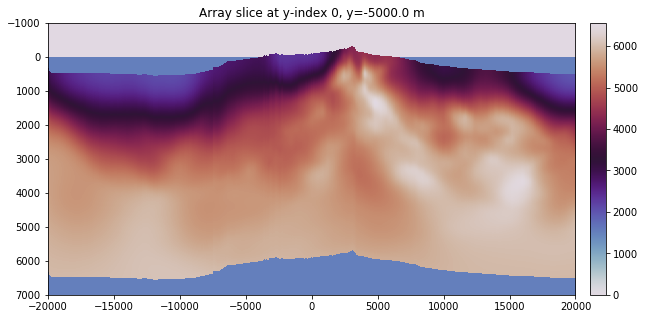

In [66]:
figure(10,5)
ax = vp6.plot(-5e3, unit='m', axis='y', cmap='twilight')
# _ = ax.set_xlim(-1e4,1e4)
# _ = ax.set_ylim(4e2,-5e2)

##### b)
depth slice.

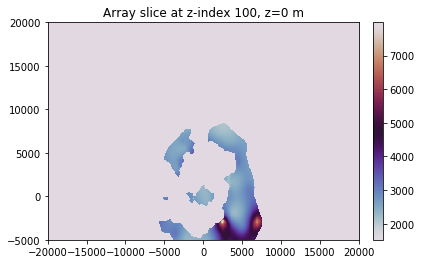

In [53]:
vp6.plot(0, unit='m', axis='z', cmap='twilight')

#### Alg.
Extrapolate the values into the air layer using the topmost non-air values. This is to ensure that the water-air and land-air interfaces do not change during the smoothing.

In [18]:
%%time 
vp7 = A3d(vp6.copy(), extent=vp5.extent)
shape = list(vp6.shape)
shape[-1] = 1 # this is important, as it allows broadcasting - 2d array would not work (3d-2d)
k_fs = find_sealvl_node(vp6)
vp7[..., :k_fs] = vp7[..., k_fs].reshape(shape) # broadcasting possible only for 3d-3d or 3d-1d
figure(10,5)
ax = vp7.plot(-5e3, unit='m', axis='y', cmap='twilight')
# _ = ax.set_xlim(-1e4,1e4)
# _ = ax.set_ylim(4e2,-5e2)

NameError: name 'find_sealvl_node' is not defined

#### Alg.
Smooth vertically with a Gaussian filter of $\sigma=100$ m which twice as the desired sampling. The filter is truncated after $4\sigma$. See the subparts for different sigmas.

CPU times: user 11 s, sys: 376 ms, total: 11.4 s
Wall time: 11.4 s


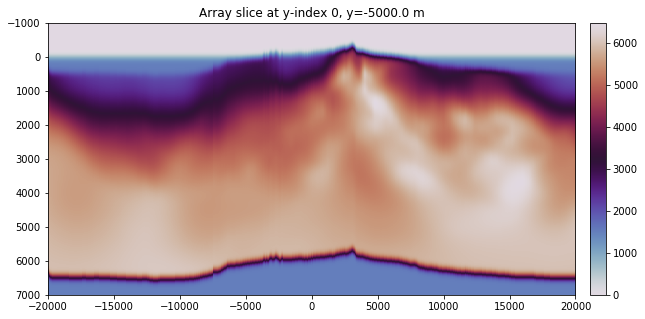

In [19]:
%%time 
from scipy.ndimage import gaussian_filter1d as gssf
dz = vp7.dx[-1]
sigma = 100 / dz
vp8 = gssf(vp7, sigma=sigma, axis=-1, truncate=4)
vp8 = A3d(vp8, extent=vp7.extent)
figure(10,5)
ax = vp8.plot(-5e3, unit='m', axis='y', cmap='twilight')

 (Side note: FWHM = 2$\sqrt{2\ln2}\sigma\approx2.35\sigma$)/

In [79]:
from scipy.ndimage import gaussian_filter1d as gssf
help(gssf)

Help on function gaussian_filter1d in module scipy.ndimage.filters:

gaussian_filter1d(input, sigma, axis=-1, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)
    One-dimensional Gaussian filter.
    
    Parameters
    ----------
    input : array_like
        The input array.
    sigma : scalar
        standard deviation for Gaussian kernel
    axis : int, optional
        The axis of `input` along which to calculate. Default is -1.
    order : int, optional
        An order of 0 corresponds to convolution with a Gaussian
        kernel. A positive order corresponds to convolution with
        that derivative of a Gaussian.
    output : array or dtype, optional
        The array in which to place the output, or the dtype of the
        returned array. By default an array of the same dtype as input
        will be created.
    mode : {'reflect', 'constant', 'nearest', 'mirror', 'wrap'}, optional
        The `mode` parameter determines how the input array is extended
     

##### b)
$\sigma=200$ m.

CPU times: user 23.2 s, sys: 476 ms, total: 23.7 s
Wall time: 23.7 s


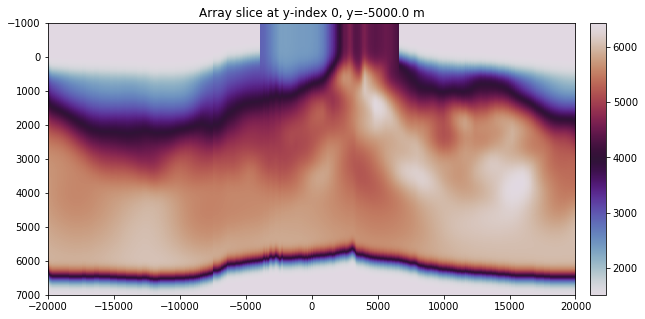

In [90]:
%%time 
dz = vp7.dx[-1]
sigma = 200 / dz
vp8 = gssf(vp7, sigma=sigma, axis=-1, truncate=4)
vp8 = A3d(vp8, extent=vp7.extent)
figure(10,5)
ax = vp8.plot(-5e3, unit='m', axis='y', cmap='twilight')

##### c) 
$\sigma=400$ m.

CPU times: user 49 s, sys: 412 ms, total: 49.4 s
Wall time: 49.4 s


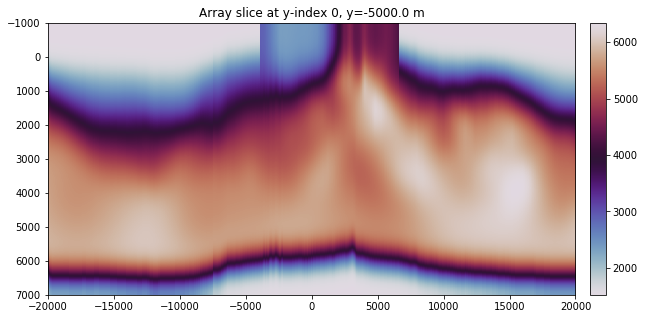

In [91]:
%%time 
dz = vp7.dx[-1]
sigma = 400 / dz
vp8 = gssf(vp7, sigma=sigma, axis=-1, truncate=4)
vp8 = A3d(vp8, extent=vp7.extent)
figure(10,5)
ax = vp8.plot(-5e3, unit='m', axis='y', cmap='twilight')

#### Alg.
Add the air-layer mask on top of the air-layer model. Note the sharp land topography and the smooth seabed.

In [20]:
%%time 
vp9 = A3d(-vp8*(mk3-1), extent=vp8.extent)

CPU times: user 1.48 s, sys: 11.7 s, total: 13.1 s
Wall time: 13.7 s


#### Fig.
Model with sharp land topography and the smooth seabed.

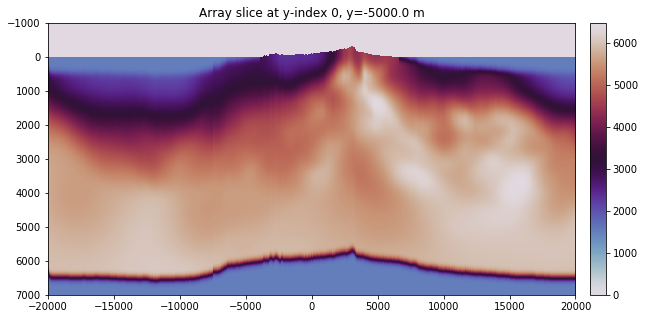

In [23]:
%mi
figure(10,5)
ax = vp9.plot(-5e3, unit='m', axis='y', cmap='twilight')

#### Alg.
Downsample vertically.

In [ ]:
%%time 
vp10 = resample(vp9, 50, 50, 50)
vp10 = A3d(vp10.copy(), extent=vp9.extent) # copy is key, otherwise extent is wrong

#### Fig.
Model downsampled vertically.

<IPython.core.display.Javascript object>


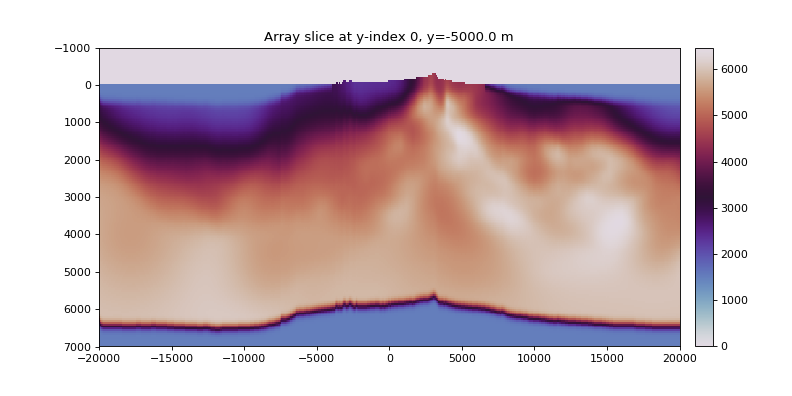

In [38]:
figure(10,5)
ax = vp10.plot(-5e3, unit='m', axis='y', cmap='twilight')

#### Alg.
Cut off the padding to get the **final** model.

In [22]:
# code 
x1 = -2.0e4
x2 = +2.0e4
y1 = -5.0e3
y2 = +2.0e4
z1 = -1.0e3
z2 = +5.0e3
box = [x1, x2, y1, y2, z1, z2]
vp11 = A3d(vp10.carve(box))

NameError: name 'vp10' is not defined

#### Fig.
Final model.

##### a)
depth slice. Note that shallow water has an intermediate velocity between water and shallow sediment. This can be reduced by smoothing a bit less.

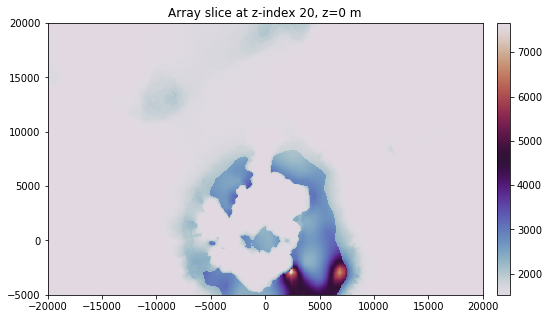

In [65]:
%mi
figure(10,5)
ax = vp11.plot(-0, unit='m', axis='z', cmap='twilight', aspect='equal')

##### b)
vertical slice.

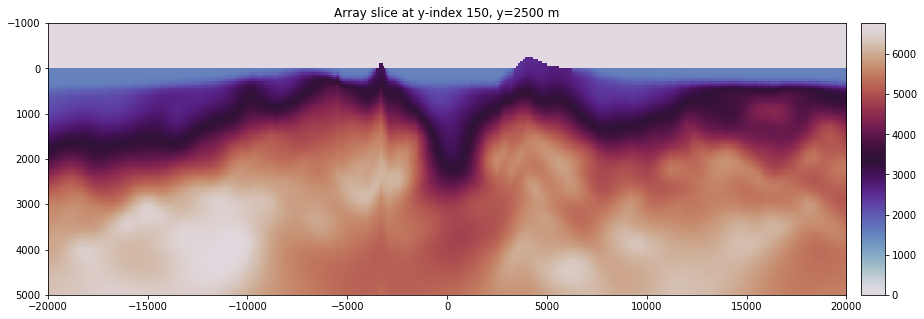

In [79]:
%mi
figure(15,5)
ax = vp11.plot(2500, unit='m', axis='y', cmap='twilight')

#### Fig.
Final model with **superimposed bathymetry** and topography.

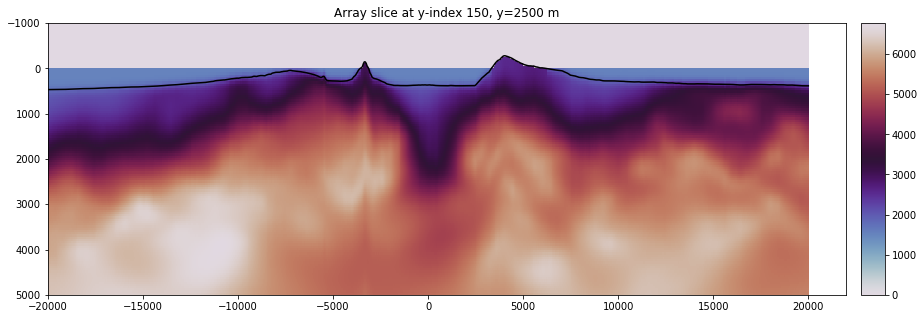

In [98]:
# code 
from fwilight.ndad import A2d
# ad hoc fixing weird extent of surface
extent = bt.extent
if extent[1][0] > extent[1][1]:
    extent[1] = extent[1][::-1]

%mi
figure(15,5)
kw_y = dict(coord=2500,  unit='m', axis='y')
ax = vp11.plot(**kw_y, cmap='twilight')
ax = A2d(bt, extent=extent).plot_slice(**kw_y, c='k')

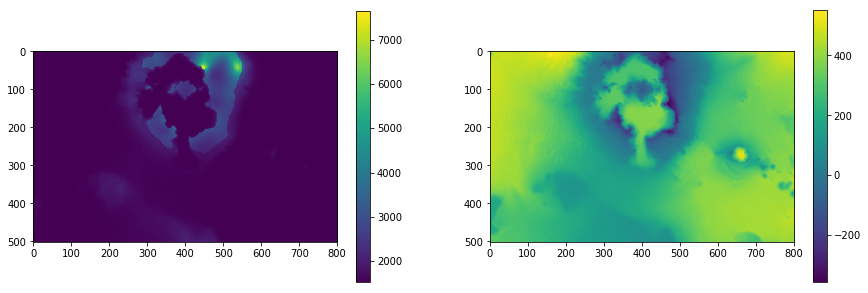

In [59]:
# code 
figure(15,5)
plt.subplot(121)
plt.imshow(np.array(vp11[...,20]).T)
plt.colorbar()
plt.subplot(122)
plt.imshow(np.array(bt).T)
plt.colorbar()

#### Alg.
Save the final model.

In [50]:
%%time 
# str(np.array(vp11.extent).flatten()).replace(" ", "").replace(".", "_")
path = pro.path['start_mods']
name = 'srModel_it5_velocity_19-04-25_-20000_20000_-5000_20000_-1000_5000.vtr'
fname = path + name
vp11.save(fname)

CPU times: user 16.3 s, sys: 9.76 s, total: 26 s
Wall time: 48.9 s


#### Alg.
Read the final model and save as `.mmp` for faster access. 

In [60]:
%%time 
path = pro.path['start_mods']
name = 'srModel_it5_velocity_19-04-25_-20000_20000_-5000_20000_-1000_5000.vtr'
fname = path + name
a = A3d(StartVp(fname, extent=vp11.extent, shape=vp11.shape, overwrite=0, overwrite_mmp=0))

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.07 ms


In [26]:
vp11.shape

(801, 501, 121)

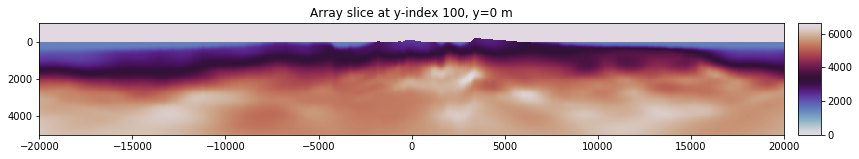

In [66]:
figure(14,4)
a.plot(0, unit='m', cmap='twilight', aspect='equal')

#### Fig.
Comparison to Ben's and Brennah's versions.

##### c)
Ben's version.

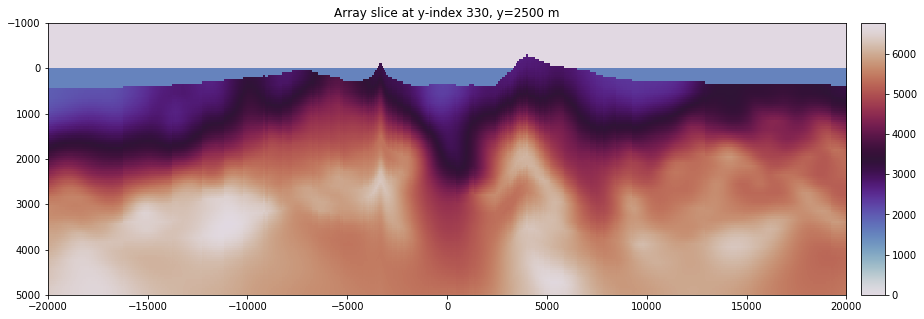

In [81]:
# code 
figure(15,5)
ax = A3d(bh).plot(2500, unit='m', axis='y', cmap='twilight')
_ = ax.set_xlim(-2e4,2e4)
_ = ax.set_ylim(5e3,-1.0e3)

##### c)
Brennah's version.

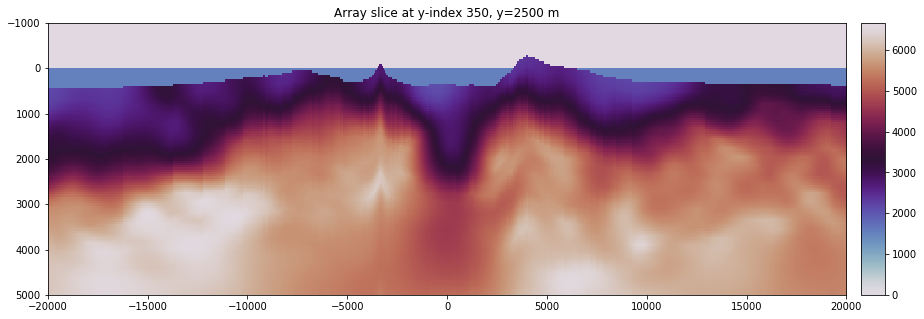

In [80]:
# code 
figure(15,5)
ax = A3d(bm).plot(2500, unit='m', axis='y', cmap='twilight')
_ = ax.set_xlim(-2e4,2e4)
_ = ax.set_ylim(5e3,-1.0e3)

#### Fig.
Comparison to the Ben's version in terms of the topography imprint due to raw re-shearing.

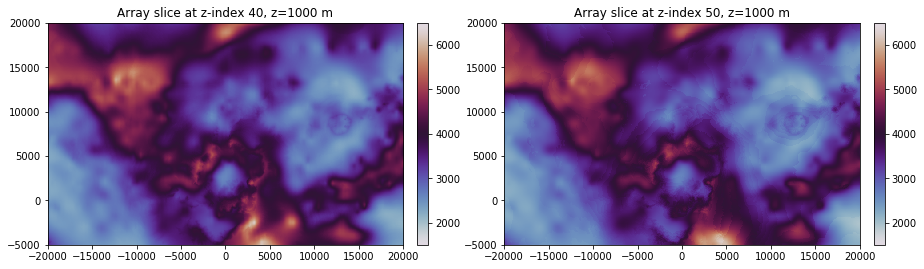

In [107]:
# note the topographic imprint in the velocity in the right model
kws = dict(unit='m', axis='z', cmap='twilight', aspect='equal', vmin=1500, vmax=6500)
figure(15,5)
plt.subplot(121)
ax = vp11.plot(1000, **kws)
plt.subplot(122)
ax = A3d(bh).plot(1000, **kws)
_ = ax.set_xlim(-2e4,2e4)
_ = ax.set_ylim(-5.0e3, 2e4)

### Automated

### Old workflow

#### Fig.
 Isotropic Vp (Ben Heath, 18-04-24) after re-shearing.

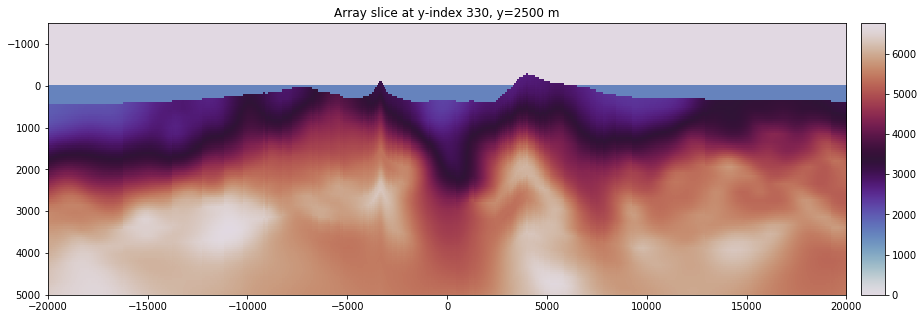

In [77]:
# code 
figure(15,5)
ax = A3d(bh).plot(2500, unit='m', axis='y', cmap='twilight')
_ = ax.set_xlim(-2e4,2e4)

In [76]:
# code 
from fullwavepy.ioapi.proteus import ProteusExperiment
from fwilight.ndat import A3d
lll(40)
pro = ProteusExperiment()
bh = pro.svp['bh']['18-04-24']

#### Fig.
 Isotropic Vp (Brennah McVey et al. 2020)  after re-shearing.

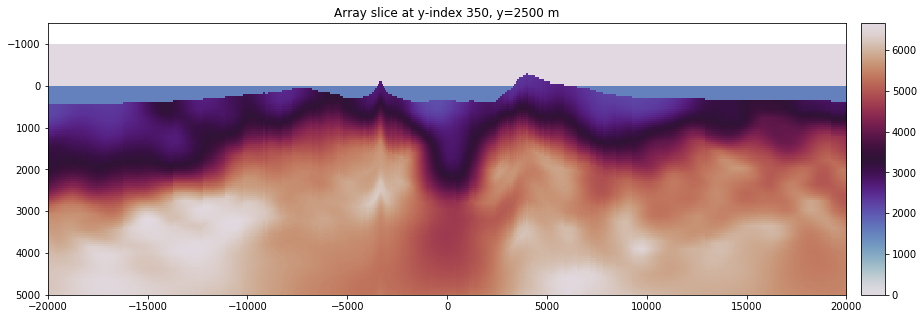

In [75]:
# code 
figure(15,5)
ax = A3d(bm).plot(2500, unit='m', axis='y', cmap='twilight')
_ = ax.set_xlim(-2e4,2e4)
_ = ax.set_ylim(5e3,-1.5e3)

In [74]:
%%time 
from fullwavepy.ioapi.generic import ArrayFile
from fwilight.ndat import A3d
lll(40)
nx = int((5e4 - -3e4) / 50 + 1)
ny = int((2e4 - -1.5e4) / 50 + 1)#
nz = 221
bm = ArrayFile('Brennah_whole_model_19-10-30.sgy', '/home/kmc3817/heavy_PhD/start_mods', 
               ).read(shape=(nx,ny,nz), extent=[[-3e4,5e4],[-1.5e4,2e4],[-1e3,1e4]])
a = A3d(bm)

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 3.33 ms


#### Fig.
Sea level and max land elevation (Heath19, 18-04-24).

In [33]:
bh = pro.svp['bh']['18-04-24']

Figures below show that array index 20 along Z axis is the largest to be entirely above Santorini land mass.

In [35]:
# plot_4zslices(bh, range(19,23), xlim=(-10e3, +10e3), ylim=(-10e3, +10e3)) # FIXME

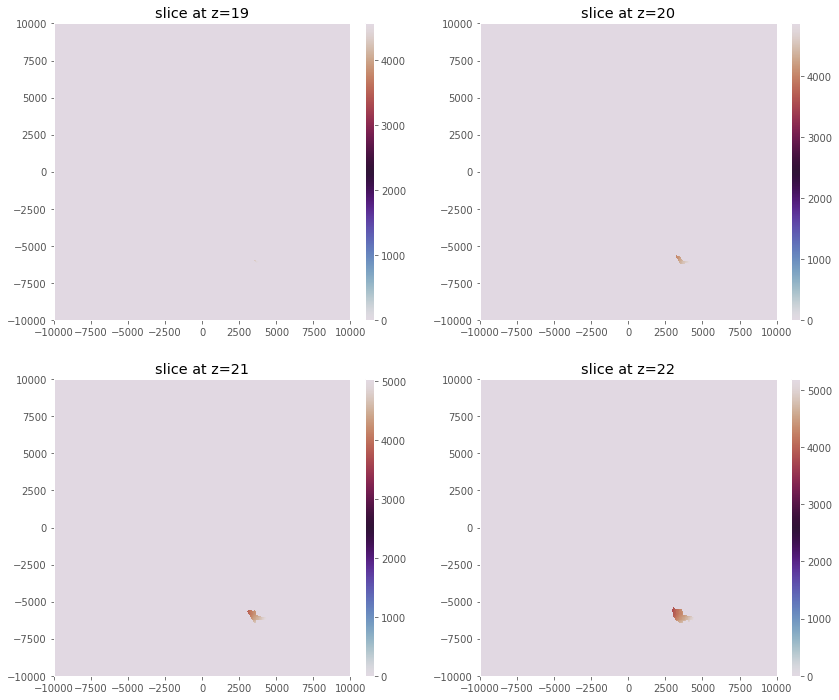

In [72]:
plot_4zslices(bh, range(19,23), xlim=(-10e3, +10e3), ylim=(-10e3, +10e3))

Figures below show that array index 29 along Z axis is the closest to sea-surface slice. 

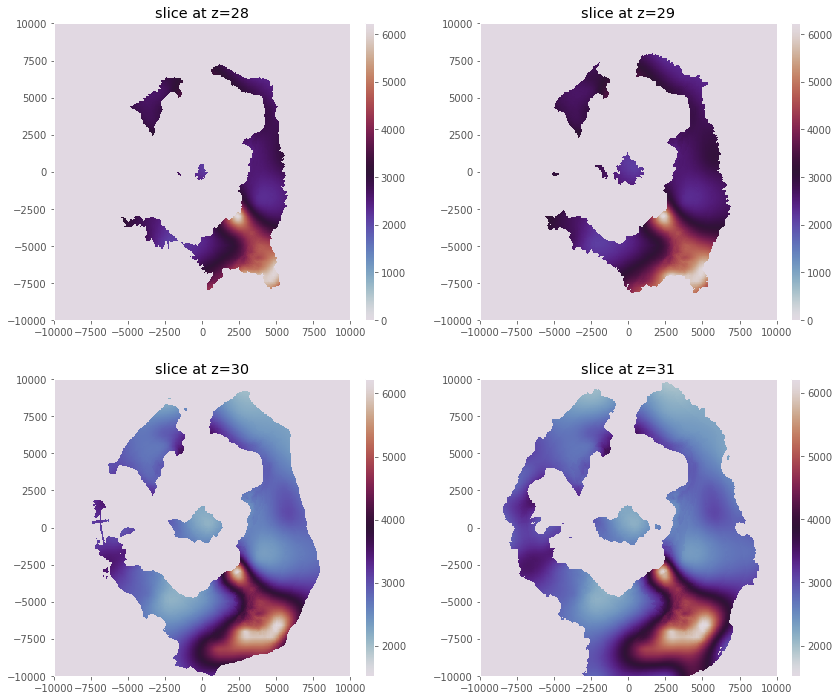

In [73]:
plot_4zslices(bh, range(28,32), xlim=(-10e3, +10e3), ylim=(-10e3, +10e3))

An even closer look below shows that the **max index of air layer is 29 and, consequently, the min index of water is 30. Sea surface is anywhere in between**. Function `plt.imshow` centers the pixels at integers (unless the extent is passed to it), so first pixel extends between (-0.5,0.5) along both X and Y.

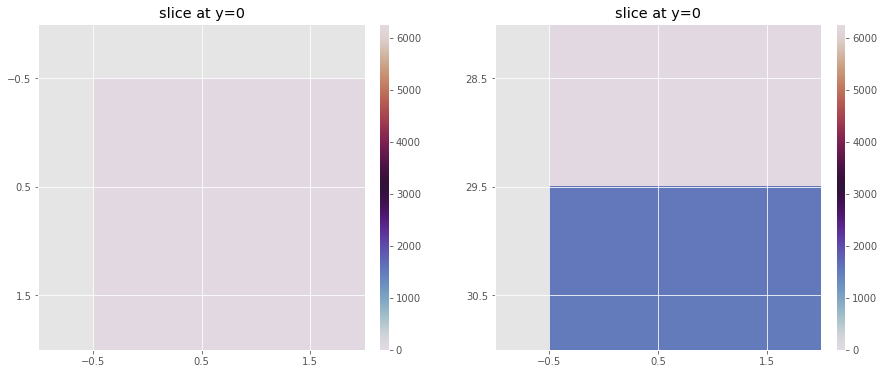

In [48]:
# plot 
figure(15,6)
plt.subplot(121)
ax = bh.plot(noextent=True)
ax.set_xlim(-1,2)
ax.set_ylim(2,-1)
aspeqt(ax)
ax.set_xticks(np.arange(-.5,2.5,1))
ax.set_yticks(np.arange(-.5,2.5,1))
ax.grid()

plt.subplot(122)
ax = bh.plot(noextent=True)
ax.set_xlim(-1,2)
ax.set_ylim(31,28)
aspeqt(ax)
ax.set_xticks(np.arange(-.5,2.5,1))
ax.set_yticks(np.arange(28.5,31.5,1))
ax.grid()

Exact position of the sea surface is essential since **all SEGY coordinates (source and receiver positions) are measured relative to it**.

Now, we can assume 29.5 and check if OBSes sit exactly at the seabed. We can also shear the MATLAB model ourselves.

In [29]:
bh.k_sea # change it

30

##### (Water) velocity distribution

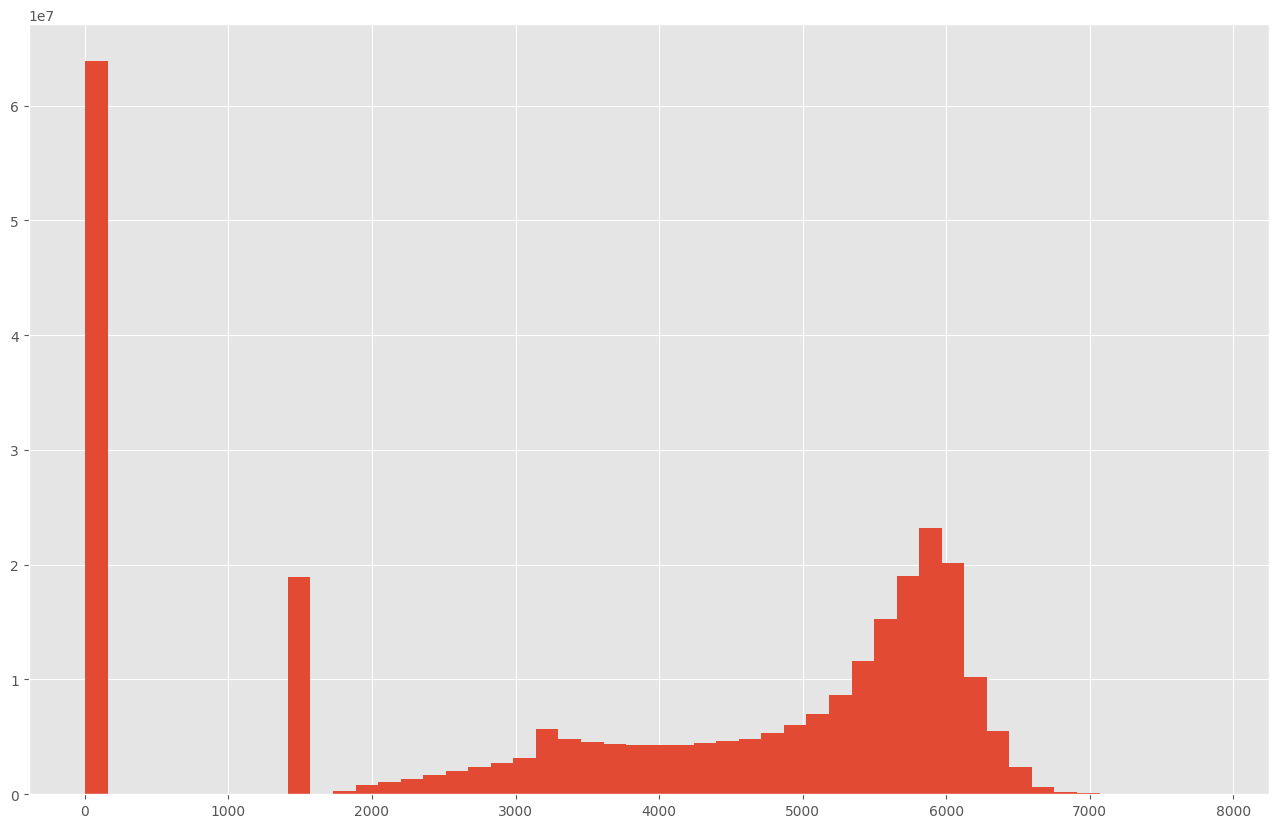

In [114]:
figure(16,10)
_ = plt.hist(bh.flatten(), bins=50)
plt.grid()

There is some variability of water velocity.

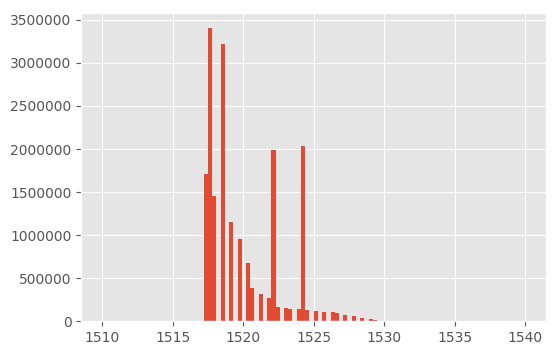

In [128]:
figure(6,4)
_ = plt.hist(bh.flatten(), range=(1510,1540), bins=100)
plt.grid()

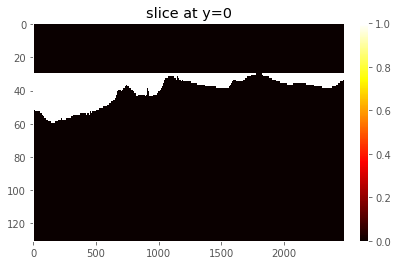

In [108]:
((bh > 0) & (bh < 1550)).astype(int).plot(cmap='hot', noextent=True)

#### Alg.
Clipping to sea surface.

In [49]:
a = bm.read(shape=(nx,ny,nz))

(22, 17)

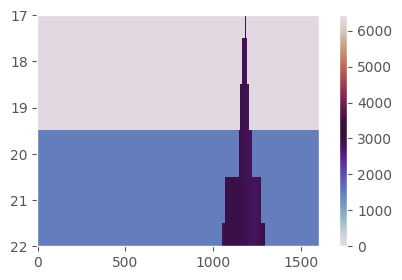

In [54]:
plot_image(a[:,0,:])
plt.ylim(22,17)

checked: with itmin=19 there is still one-cell layer of air!

In [ ]:
CAVEAT !!! itmin max starts from 0!!!!!!!!!!!!!!!!!!!!!!!!
if we passed 221 SU will silently add a layer of 0value at the bottom

In [30]:
!segyread tape={bm.fname} | suwind itmin=20 itmax=220 | segyhdrs | segywrite tape=tmp.sgy

3200+0 records in
6+1 records out
3200 bytes (3.2 kB, 3.1 KiB) copied, 0.0126006 s, 254 kB/s
6+1 records in
1+0 records out
3200 bytes (3.2 kB, 3.1 KiB) copied, 8.2563e-05 s, 38.8 MB/s


In [31]:
tmp = SgyFile('tmp.sgy', './')
# tmp.surange()
a_clip = tmp.read(shape=(nx,ny,201), overwrite_mmp=1)

INFO:fullwavepy.ioapi.generic.read_any: Saving .//tmp.mmp...


(5, 0)

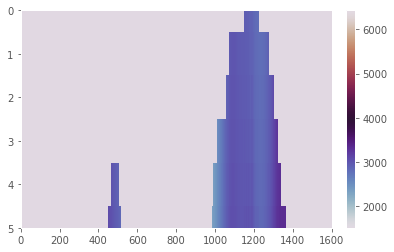

In [32]:
plot_image(a_clip[:,0,:])
plt.ylim(5,0)

In [33]:
!cp tmp.sgy {path + 'start_mods/Brennah_whole_model_19-10-30_sea-clipped.sgy'} 

# Density

Density is calculated based on P-wave velocity by the FWI code. See the thesis for more details.

# Appendix

### To port to codebase
potentially with fixes required.

#### Alg.
Finding array index of the sea surface, provided it is at 0 m according to the vp.extent.

In [23]:
def find_sealvl_node(vp):
    z1 = vp.extent[-1][0]
    dz = vp.dx[-1]
    k_sea = int((0 - z1) / dz)
    return k_sea

#### Alg.
(NOT used) ModPrep by MW.

In [71]:
# from lib_fwi_project_CLASS import Modprep_File
# mp = Modprep_File()

In [28]:
!run_modprep.sh

Error. Re-run with required arguments: 
keyfile=$1


In [ ]:
    self.proj.inp.mp = Modprep_File('ModPrep', self.proj, **kwargs)
    self.proj.inp.mp.Create(fname_sgy, dims_old, dxs_old, fname_sgy, dxs_new, quantity=quantity)
    self.proj.inp.mp.Run()

# ...